In [1]:
!pip install gudhi

     |████████████████████████████████| 28.1MB 127kB/s 


In [4]:
!pip install mayavi

     |████████████████████████████████| 7.1MB 3.5MB/s 
     |████████████████████████████████| 184kB 31.3MB/s 
     |████████████████████████████████| 204kB 43.3MB/s 
     |████████████████████████████████| 6.2MB 17.4MB/s 
     |████████████████████████████████| 5.1MB 27.9MB/s 
     |████████████████████████████████| 5.8MB 20.7MB/s 
     |████████████████████████████████| 103.4MB 38kB/s 
  ERROR: Failed building wheel for mayavi
  Running setup.py clean for mayavi
  Created wheel for apptools: filename=apptools-5.1.0-cp37-none-any.whl size=228756 sha256=a2b28e3bd50638a4a572a6f37fdf3b2862a2b7f75c785f2da3e01fa67afcea62
  Stored in directory: /root/.cache/pip/wheels/55/c1/79/64868a3cdd74eb83029044c0adfd490210fe9126bcf337daec
  Created wheel for envisage: filename=envisage-5.0.0-cp37-none-any.whl size=319217 sha256=935008fc409f771d1e034dc921ad3f78d24cafbede7d573b6f5fd95929cdfb18
  Stored in directory: /root/.cache/pip/wheels/9c/b0/c6/b933e75c4deafad7597fda9d9664b46e7d8a1e1190e8f42186
  Cre

In [57]:
!pip install POT

     |████████████████████████████████| 440kB 4.2MB/s 


In [58]:
!pip install eagerpy

# Imports

In [62]:
from IPython.display import Image
from os import chdir
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
import pandas as pd
from pylab import *
from sklearn.neighbors import KernelDensity
import seaborn as sns
import pickle
from gudhi.wasserstein import wasserstein_distance
import torch
from torch.optim.lr_scheduler import LambdaLR
import tensorflow as tf
%matplotlib inline

# Exploring simplical complexes with Rips and Alpha filtration

In [26]:
#Data set and experiment from Kovacev-Nikolic et al (https://arxiv.org/pdf/1412.1394.pdf)
path_file = "./"
files_list = [
    '1anf.corr_1.txt', 
    '1ez9.corr_1.txt', 
    '1fqa.corr_2.txt', 
    '1fqb.corr_3.txt', 
    '1fqc.corr_2.txt', 
    '1fqd.corr_3.txt', 
    '1jw4.corr_4.txt', 
    '1jw5.corr_5.txt', 
    '1lls.corr_6.txt', 
    '1mpd.corr_4.txt', 
    '1omp.corr_7.txt', 
    '3hpi.corr_5.txt', 
    '3mbp.corr_6.txt', 
    '4mbp.corr_7.txt'
]
corr_list = [
    pd.read_csv(
        path_file + u, 
        header = None, 
        delim_whitespace = True
    ) for u in files_list
]

In [27]:
#compute the matrix of distances associated to each configuration
dist_list = [1 - np.abs(c) for c in corr_list]
D = dist_list[0]
print("distance matrix")
D.head()

distance matrix


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369
0,0.000000,0.076200,0.171364,0.378207,0.461747,0.493499,0.478665,0.432338,0.568455,0.639504,0.876696,0.987487,0.971474,0.752469,0.785661,0.753362,0.926726,0.891183,0.763683,0.861939,0.957064,0.834729,0.801634,0.979382,0.913509,0.839663,0.929590,0.993115,0.924922,0.922717,0.993688,0.993023,0.770953,0.784322,0.740372,0.672799,0.770868,0.706807,0.796060,0.706772,...,0.730223,0.774431,0.743020,0.799158,0.671402,0.643874,0.675207,0.602705,0.559920,0.546235,0.560099,0.552504,0.544802,0.545891,0.565868,0.600064,0.613328,0.613752,0.652322,0.707323,0.722034,0.730058,0.786749,0.773707,0.766714,0.815753,0.801413,0.833213,0.770803,0.688172,0.694159,0.723059,0.660802,0.614051,0.660601,0.686334,0.640850,0.617944,0.695108,0.748451
1,0.076200,0.000000,0.122763,0.233837,0.350744,0.406213,0.425202,0.381799,0.541636,0.646580,0.874730,0.980564,0.981461,0.791195,0.835268,0.824335,0.988385,0.971576,0.847729,0.937372,0.962880,0.923792,0.890868,0.940083,0.987789,0.918542,0.992630,0.918488,0.933675,0.944592,0.927787,0.915498,0.682550,0.691234,0.656562,0.580834,0.718290,0.665421,0.783539,0.717578,...,0.713620,0.688022,0.674322,0.706879,0.675207,0.638185,0.648848,0.652654,0.639287,0.597886,0.617986,0.655068,0.653195,0.633744,0.655829,0.706906,0.709955,0.690718,0.735362,0.791449,0.788910,0.784520,0.845639,0.836736,0.843118,0.894596,0.894162,0.927606,0.869419,0.797502,0.817461,0.844610,0.781266,0.740222,0.793586,0.808770,0.754748,0.730646,0.804961,0.848953
2,0.171364,0.122763,0.000000,0.084642,0.131528,0.148980,0.162259,0.164105,0.333175,0.480605,0.728596,0.878333,0.955878,0.761321,0.863604,0.850384,0.912823,0.949718,0.909342,0.931740,0.811086,0.958686,0.963492,0.726269,0.842220,0.937272,0.781078,0.682947,0.989341,0.973549,0.713763,0.650806,0.398764,0.430297,0.400250,0.367524,0.522562,0.507607,0.646142,0.615129,...,0.695602,0.695092,0.667749,0.699321,0.638518,0.605190,0.623142,0.581264,0.565534,0.525747,0.531880,0.555328,0.555036,0.518660,0.549644,0.620678,0.618889,0.588264,0.652685,0.734626,0.720356,0.710494,0.798838,0.785443,0.804563,0.881797,0.885763,0.934006,0.848658,0.748390,0.782234,0.813481,0.718610,0.666239,0.742311,0.740322,0.667525,0.653546,0.742430,0.766030
3,0.378207,0.233837,0.084642,0.000000,0.045478,0.132107,0.217299,0.293902,0.494307,0.675635,0.876268,0.991366,0.919455,0.726101,0.814194,0.811663,0.996419,0.984417,0.877307,0.983443,0.872731,0.991227,0.973019,0.752899,0.866137,0.939076,0.761071,0.659739,0.954954,0.980399,0.664877,0.553946,0.344309,0.408559,0.431622,0.439792,0.645070,0.673255,0.818156,0.841465,...,0.737892,0.693142,0.674475,0.667690,0.687913,0.658524,0.640351,0.679618,0.693402,0.643013,0.657866,0.712014,0.719348,0.678863,0.711073,0.781851,0.781384,0.746506,0.802262,0.875486,0.859203,0.840488,0.913671,0.892687,0.917118,0.983563,0.994598,0.976144,0.954957,0.885855,0.913930,0.929677,0.853475,0.813717,0.868041,0.856491,0.797437,0.781044,0.842591,0.858435
4,0.461747,0.350744,0.131528,0.045478,0.000000,0.059280,0.146850,0.297257,0.511751,0.734412,0.939161,0.904015,0.837147,0.628354,0.744318,0.768388,0.981398,0.988109,0.897541,0.943569,0.810338,0.895153,0.849603,0.619624,0.715071,0.753349,0.556484,0.467144,0.862018,0.803069,0.440527,0.388396,0.183934,0.291512,0.340658,0.417123,0.643156,0.719489,0.884441,0.921742,...,0.656162,0.607924,0.598170,0.596286,0.637303,0.599548,0.577877,0.652617,0.673773,0.613776,0.641983,0.714537,0.728334,0.679051,0.726305,0.815579,0.817331,0.775754,0.842191,0.933748,0.914748,0.886933,0.969051,0.933527,0.967383,0.952075,0.935762,0.910479,0.989322,0.938696,0.967195,0.979578,0.889375,0.841519,0.895967,0.874522,0.804538,0.779865,0.841695,0.849836


# Rips filtration of Protein binding distance matrix

In [28]:
skeleton_protein = gd.RipsComplex(
    distance_matrix = D.values, 
    max_edge_length = 0.8
)
Rips_simplex_tree_protein = skeleton_protein.create_simplex_tree(max_dimension = 2)

In [29]:
print("Number of simplcies in the Rips complex")
Rips_simplex_tree_protein.num_simplices()

Number of simplcies in the Rips complex


1626660

# Alpha filtration of Protein binding distance matrix

Our data set does not belong to euclideen space $\mathbb R^p$ and we are not in position to directly compute a Delaunay Triangulation in the metric space, using the pairwise distances. Therefore we use  Multidimensional Scaling (MDS) to find a representation of $n$ points in a space $\mathbb R^p$ that preserves as well as possible the pairwise distances between the $n$ points in the original metric space. 

In [19]:
from sklearn.manifold import MDS
 
embedding = MDS(n_components = 3, dissimilarity = 'precomputed')
X_transformed = embedding.fit_transform(D)
X_transformed.shape

(370, 3)

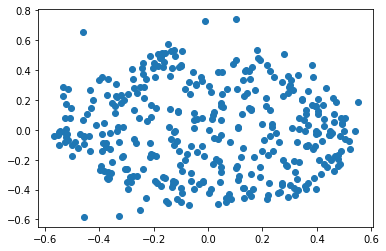

In [20]:
fig = plt.figure()
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], label = 'MDS');

In [21]:
alpha_complex = gd.AlphaComplex(points = X_transformed)

In [22]:
st_alpha = alpha_complex.create_simplex_tree()

In [24]:
print("The number of alpha simplices")
print(st_alpha.num_simplices())

The number of alpha simplices
9209


The number of simplexes in the Alpha complex is much smaller then for the Rips complex.

# Examples of sublevel sets of functions using cubical complexes

In [34]:
#https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-cubical-complexes.ipynb
f = open("./crater_tuto", "rb")
crater = pickle.load(f)
f.close()

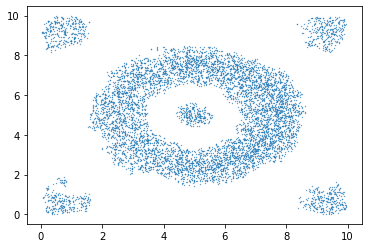

In [35]:
#visualize point cloud
plt.scatter(crater[:, 0], crater[:, 1], s = 0.1)

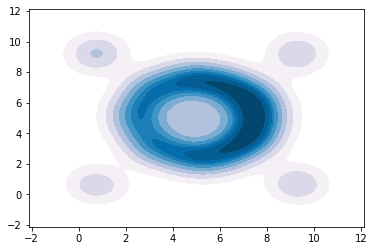

In [36]:
#Instead of directly defining a Rips complex or an alpha complex on the point cloud, 
#we want to study the upper level sets of a density estimator computed on the point cloud.
sns.kdeplot(
    x = crater[:, 0], 
    y = crater[:, 1], 
    shade = True, 
    cmap = "PuBu", 
    bw_method = .3
)

In [37]:
xval = np.arange(0, 10, 0.05)
yval = np.arange(0, 10, 0.05)
nx = len(xval)
ny = len(yval)
kde = KernelDensity(kernel = 'gaussian', bandwidth = 0.3).fit(crater)
positions = np.array([[u, v] for u in xval for v in yval])

In [38]:
filt_values = -kde.score_samples(X = positions)
print("range of filtation: ")
print(min(filt_values), max(filt_values))

range of filtation: 
3.2652121885802146 26.527204685017267


In [41]:
cc_density_crater = gd.CubicalComplex(
    dimensions = [nx ,ny], 
    top_dimensional_cells = filt_values
)
print("Compute the cubical complex filtration based on the grid using the filtration values:")
print("...")
print("The number of simplices is then: ")
cc_density_crater.num_simplices()

Compute the cubical complex filtration based on the grid using the filtration values:
...
The number of simplices is then: 


160801

# Persistent homology and persistence diagrams

In [43]:
#Data set & experiment from Kovacev-Nikolic et al. (https://arxiv.org/pdf/1412.1394.pdf)
D0 = dist_list[0]

In [44]:
#Build Rips complex from distance matrix:
skeleton_protein0 = gd.RipsComplex(
    distance_matrix = D0.values, 
    max_edge_length = 0.8
) 

Rips_simplex_tree_protein0 = skeleton_protein0.create_simplex_tree(max_dimension = 2)

In [46]:
#Compute persistence
BarCodes_Rips0 = Rips_simplex_tree_protein0.persistence()
print("Each element in the list is a tuple (dim,(b,d)) where dim is a dimension, b is birth parameter and d is death parameter.")
print("These 20 topolological features have dimension 1, they corresponds to holes of dimension 1.")
for i in range(20):
    print(BarCodes_Rips0[i])

Each element in the list is a tuple (dim,(b,d)) where dim is a dimension, b is birth parameter and d is death parameter.
These 20 topolological features have dimension 1, they corresponds to holes of dimension 1.
(1, (0.07963602000000003, 0.35798637))
(1, (0.12677510000000003, 0.39508646999999997))
(1, (0.26003449999999995, 0.5273952))
(1, (0.07943339999999999, 0.31429881000000004))
(1, (0.08248586999999996, 0.30429980999999995))
(1, (0.11378021999999999, 0.31171713999999995))
(1, (0.07726765000000002, 0.26078758))
(1, (0.09107215000000002, 0.25065161999999996))
(1, (0.0709843, 0.22765623000000001))
(1, (0.09347402000000005, 0.24999733000000002))
(1, (0.07013614000000001, 0.22504734000000004))
(1, (0.08752541000000003, 0.20355559))
(1, (0.21541215000000002, 0.32814707))
(1, (0.06835270000000004, 0.17527247))
(1, (0.08857625000000002, 0.19539684000000002))
(1, (0.08241111999999995, 0.18353136999999997))
(1, (0.10362273, 0.20264340000000003))
(1, (0.09289979999999998, 0.19181444000000003

0-dimensional features are the red points (holes of dimension 0, namely connected components).
 The last connected component dies at infinity in the filtration (red point at the top). 
 The 1-dimensional features are represented in blue


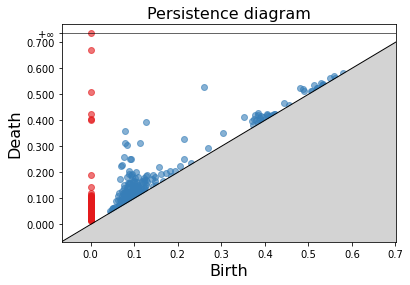

In [72]:
#Plot the points (birth, death) in the so-called persistence diagram
gd.plot_persistence_diagram(BarCodes_Rips0)
print("0-dimensional features are the red points (holes of dimension 0, namely connected components).\n The last connected component dies at infinity in the filtration (red point at the top). \n The 1-dimensional features are represented in blue")

# Optimizing Points with weak $\alpha$- complex

---



We compute the persistent homology in dimension 1 of some $\alpha$ filtration built on the points, and want to maximize its total persistence. For this, we define a loss function that rewards total persistence and penalizes points outside of the disk.

In [52]:
def myloss(pts):
    alpha = gudhi.AlphaComplex(points=pts)
    # Build the Delaunay triangulation
    st = alpha.create_simplex_tree(default_filtration_value=True)
    X = pts.detach().numpy()
    for s in st.get_skeleton(1):
        if len(s[0]) == 1:
            # vertex
            st.assign_filtration(s[0], 0)
        else:
            # edge length
            st.assign_filtration(s[0], ((X[s[0][1]] - X[s[0][0]]) ** 2).sum())
    # For triangles, use the max of the edges
    st.make_filtration_non_decreasing()
    st.compute_persistence()
    p = st.persistence_pairs()
    # Keep only pairs that contribute to H1, i.e. (edge, triangle), and separate birth (p1b) and death (p1d)
    p1b = torch.tensor([i[0] for i in p if len(i[0]) == 2])
    p1d = torch.tensor([i[1] for i in p if len(i[0]) == 2])
    if len(p1b) == 0:
        return torch.tensor(0., requires_grad=True)
    # Compute the distance between the extremities of the birth edge
    b = torch.norm(pts[p1b[:,1]] - pts[p1b[:,0]], dim=-1, keepdim=True)
    # For the death triangle, compute the maximum of the pairwise distances
    d_1 = torch.norm(pts[p1d[:,1]] - pts[p1d[:,0]], dim=-1, keepdim=True)
    d_2 = torch.norm(pts[p1d[:,1]] - pts[p1d[:,2]], dim=-1, keepdim=True)
    d_3 = torch.norm(pts[p1d[:,2]] - pts[p1d[:,0]], dim=-1, keepdim=True)
    d = torch.max(d_1, torch.max(d_2, d_3))
    # Same as the finite part of st.persistence_intervals_in_dimension(1), but differentiable
    diag1 = torch.cat((b,d), 1)
    # Total persistence is a special case of Wasserstein distance
    perstot1 = wasserstein_distance(diag1, [], order=1, enable_autodiff=True)
    # Stay within the unit disk
    disk = (pts ** 2).sum(-1) - 1
    disk = torch.max(disk, torch.zeros_like(disk)).sum()
    return -perstot1 + 1 * disk

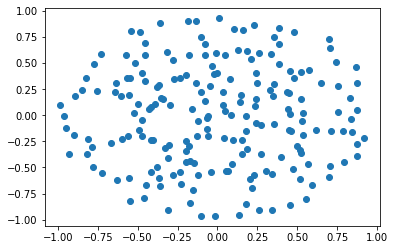

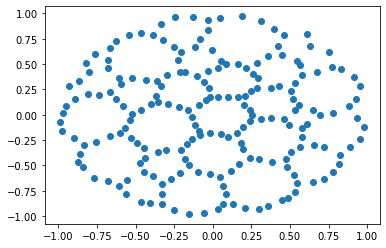

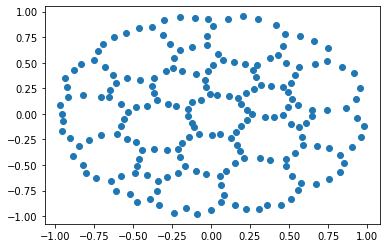

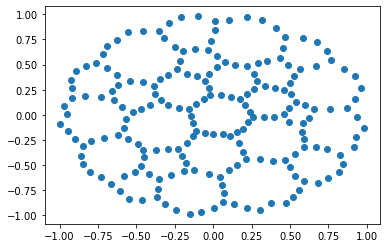

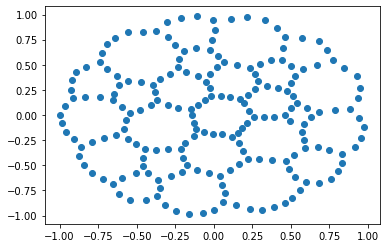

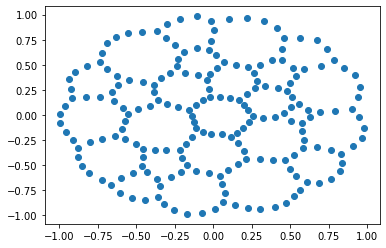

In [59]:
# Start with a square, the loss will round the corners
pts = (torch.rand((200, 2)) * 2 - 1).requires_grad_()
opt = torch.optim.SGD([pts], lr=1)
scheduler = LambdaLR(opt,[lambda epoch: 10./(10+epoch)])
for idx in range(600):
    opt.zero_grad()
    myloss(pts).backward()
    opt.step()
    scheduler.step()
    if idx % 100 == 99:
        P = pts.detach().numpy()
        plt.scatter(P[:, 0], P[:, 1])
        plt.show()

# Optimizing of Images with Pixel Filtration

We follow the experiment by https://mathieucarriere.github.io/website/

In [60]:
def Cubical(X, dim, card):
    # Parameters: X (image),
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    cc = gd.CubicalComplex(dimensions=X.shape, top_dimensional_cells=X.flatten())
    cc.persistence()
    cof = cc.cofaces_of_persistence_pairs()[0][dim]
    
    # Sort points with distance-to-diagonal
    Xs = X.shape
    pers = [X[np.unravel_index(cof[idx,1], Xs)] - X[np.unravel_index(cof[idx,0], Xs)] for idx in range(len(cof))]
    perm = np.argsort(pers)
    cof = cof[perm]
    
    # Retrieve and ouput image indices/pixels corresponding to positive and negative simplices
    D = len(X.shape)
    ocof = np.array([0 for _ in range(D*card*2)])
    for idx in range(len(cof[:min(card, cof.shape[0])])):
        ocof[D*idx:D*(idx+1)]     = np.unravel_index(cof[idx,0], X.shape)
        ocof[D*(idx+1):D*(idx+2)] = np.unravel_index(cof[idx,1], X.shape)
    return list(np.array(ocof.flatten(), dtype=np.int32))

In [63]:
class CubicalModel(tf.keras.Model):
    def __init__(self, X, dim=1, card=50):
        super(CubicalModel, self).__init__()
        self.X = X
        self.dim = dim
        self.card = card
        
    def call(self):
        d, c, D = self.dim, self.card, len(self.X.shape)
        XX = tf.reshape(self.X, [1, self.X.shape[0], self.X.shape[1]])
        
        # Turn numpy function into tensorflow function
        CbTF = lambda X: tf.numpy_function(Cubical, [X, d, c], [tf.int32 for _ in range(2*D*c)])
        
        # Compute pixels associated to positive and negative simplices 
        # Don't compute gradient for this operation
        inds = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(CbTF,XX,dtype=[tf.int32 for _ in range(2*D*c)]))
        
        # Get persistence diagram by simply picking the corresponding entries in the image
        dgm = tf.reshape(tf.gather_nd(self.X, tf.reshape(inds, [-1,D])), [-1,2])
        return dgm

In [64]:
I = np.array(pd.read_csv("./mnist_test.csv", header=None, sep=","), dtype=np.float32)
idx = np.argwhere(I[:,0] == 8)
image = np.reshape(-I[idx[8],1:], [28,28])

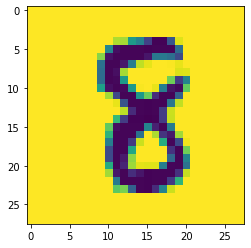

In [65]:
plt.figure()
plt.imshow(image)
plt.show()

In [66]:
card     = 50   # max number of points in the diagrams
hom      = 1    # homological dimension
n_epochs = 100  # number of optimization steps

In [67]:
X = tf.Variable(initial_value=np.array(image, dtype=np.float32), trainable=True)
model = CubicalModel(X, dim=hom, card=card)

In [68]:
optimizer = tf.keras.optimizers.SGD(learning_rate=5*1e-2)

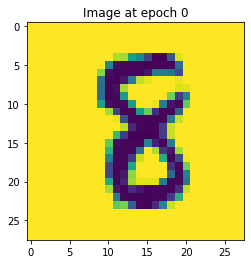

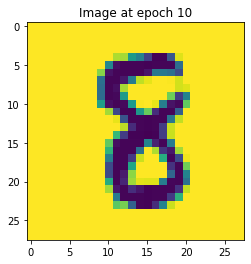

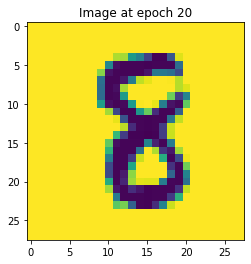

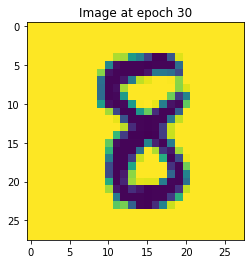

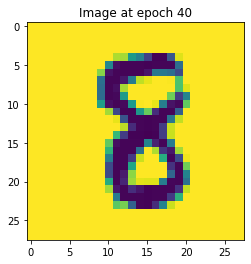

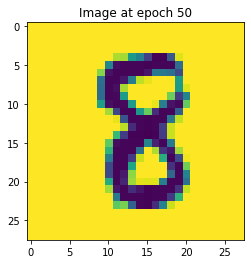

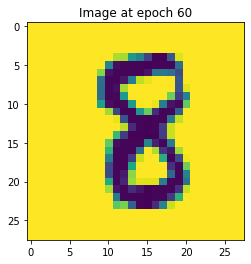

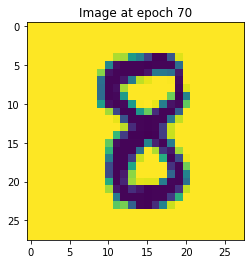

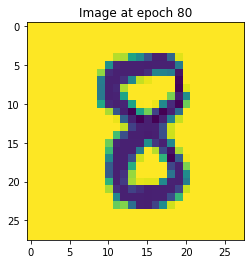

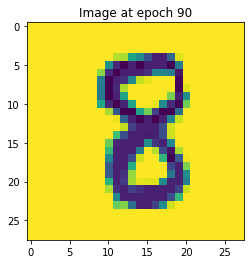

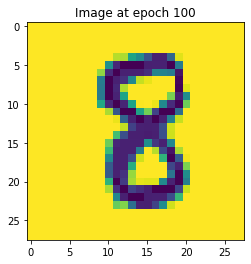

In [69]:
for epoch in range(n_epochs+1):
    
    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        dgm = model.call()
        
        # Loss is sum of squared birth coordinates
        loss = -tf.math.reduce_sum(tf.square(dgm[:,0]))
        
        # Compute and apply gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 10 == 0:
        plt.figure()
        plt.imshow(model.X.numpy())
        plt.title("Image at epoch " + str(epoch))
        plt.show()